In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
import numpy as np
from collections import Counter, defaultdict
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# stop_words = set(stopwords.words('english'))
austen = nltk.corpus.gutenberg.words('austen-sense.txt')

In [3]:
def heatmap_by_topic_doc(z_m_n, K, D):
## Generate a heatmap where x-axis is Document, y-axis is Topic, and value is frequency of assigned words
    distn = np.zeros((D, K))
    for i in range(len(z_m_n)):
        cnt = Counter()
        for j in range(len(z_m_n[i])):
            cnt[z_m_n[i][j]] += 1

        doc_len = len(z_m_n[i])
        for k in range(K):
            distn[i,k] = cnt.get(k,0) / doc_len

    sns.heatmap(distn.T,cmap='Greys', vmin=0, vmax=1)
    plt.xlabel('Document')
    plt.ylabel('Topic')
    plt.show()
    
    
def extract_topic_groups(K, z_d_ld, docs):
## Get topic groups (the actual words) from topic assignment matrix z_d_ld
    topic_groups = [ [] for _ in range(K) ]
    for i in range(len(z_d_ld)):
        for j in range(len(z_d_ld[i])):
            word = docs[i][j]
            if not word in topic_groups[z_d_ld[i][j]]:
                topic_groups[z_d_ld[i][j]].append(word)
    return topic_groups

# Using Jane Austen's **Sense**
## [1] Preprocessing
* Remove all non-words
* ~~Remove all stop words~~
* Lowercase

I looked into removing stop words, but using NLTK.corpus.stopwords reduced the total number of tokens to ~58k, too low per the instructions. Stemming and lemmatizing would further reduce this.

In [5]:
austen = ' '.join(austen)
tokenizer = RegexpTokenizer(r'\w+')
austen = tokenizer.tokenize(austen) # remove nonwords

# nltk.download('stopwords')
from nltk.corpus import stopwords
austen = [word.lower() for word in austen]
austen = [word for word in austen if not word in stopwords.words('english')] # remove stop words

# austen_list = [word.lower() for word in austen] # lowercase
austen_str = ' '.join(austen)

### [1.1] Word-to-Int mapping

In [6]:
freqs = Counter()
tokens = austen_str.lower().split()
for token in tokens:
    freqs[token] += 1                                 # freqs is dict(), i.e. freqs[word] = count
freqs = freqs.most_common()                   # now freqs is tuple of (word, count)
word2int = {freqs[i][0]:i+1 for i in range(len(freqs))}  # mapping is dict of freqs[word]=r where r=rank
int2word = {v:k for k,v in word2int.items()}

### [1.2] Split the corpus into documents on the word "chapter"

In [7]:
docs = []
start = 0
i = 0
while i < len(austen_list):
    if austen_list[i] == 'chapter':
        docs.append(austen_list[start:i-1])
        start = i
    i += 1
    
docs = docs[1:]
N_W = sum(len(doc) for doc in docs)
N_W_unique = len(set(austen_list))
N_D = len(docs)
print('Total number of tokens: ' + str(N_W))
print('Number of unique tokens: ' + str(N_W_unique))
print('Number of documents: ' + str(N_D))

Total number of tokens: 52799
Number of unique tokens: 6201
Number of documents: 49


### Collapsed Gibbs Sampling

In [8]:
K = 10
V = len(set(austen_list))
D = len(docs)
alpha = 0.1
beta = alpha

# for printing a number of words from randomly chosen topics (to compare before and after)
topic_groups_to_print = np.random.randint(0, K, 2)
number_words_to_print = 10

#### Initialization

Initialized heatmap


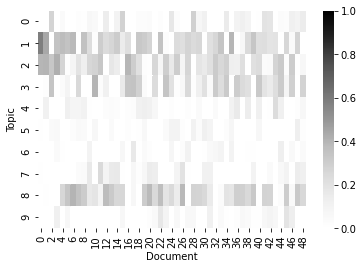

Topic group #2
family,long,estate,large,residence,norland,park,property,many,surrounding,

Topic group #7
john,recommendation,right,sakes,elinor,eager,sensibility,getting,regard,jointure,



In [9]:
z_d_ld = [] # word-topic assignment (size = # documents x len(document i)), topic<-z
n_d_k = np.zeros((D, K)) + alpha # word counts by document and topic
n_k_v = np.zeros((K, V)) + beta # word counts by topic and word2int
n_k = np.zeros(K) + V*beta # word counts by topic
for i_doc, doc in enumerate(docs):
    z_n = []
    for word in doc:
        p_z = n_k_v[:, word2int[word]] * n_d_k[i_doc] / n_k     # probability dist'n of topics
        z = np.random.multinomial(1, p_z / p_z.sum()).argmax()  # randomly sampled topic
        
        # increment this topic
        z_n.append(z)
        n_d_k[i_doc, z] += 1
        n_k_v[z, word2int[word]] += 1
        n_k[z] += 1
    z_d_ld.append(np.array(z_n))
    
print('Initialized heatmap')
heatmap_by_topic_doc(z_d_ld, K, D)

topic_groups = extract_topic_groups(K, z_d_ld, docs)
for group_id in topic_groups_to_print:
    print('Topic group #' + str(group_id))
    for i in range(number_words_to_print):
        print(topic_groups[group_id][i],end=',')
    print('\n')

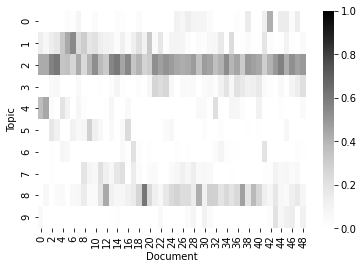

Topic group #2
chapter,family,long,settled,centre,manner,engage,general,opinion,acquaintance,

Topic group #7
yes,disgust,ungracious,encouraged,violent,neighbourhood,acknowledged,intimacy,marianne,night,



In [10]:
num_iter = 100
for i in range(num_iter):
    for i_doc, doc in enumerate(docs):
        for i_word, word in enumerate(doc):
            z = z_d_ld[i_doc][i_word]
            # decrement this topic
            n_d_k[i_doc, z] -= 1
            n_k_v[z, word2int[word]] -= 1
            n_k[z] -= 1
            
            # draw new topic
            p_z = n_d_k[i_doc] * n_k_v[:, word2int[word]] / n_k
            new_z = np.random.multinomial(1, p_z / p_z.sum()).argmax()
            
            # increment new topic
            z_d_ld[i_doc][i_word] = new_z
            n_d_k[i_doc, new_z] += 1
            n_k_v[new_z, word2int[word]] += 1
            n_k[new_z] += 1
    print('Iteration #', i)
    clear_output(wait=True)
    
heatmap_by_topic_doc(z_d_ld, K, D)
topic_groups = extract_topic_groups(K, z_d_ld, docs)
for group_id in topic_groups_to_print:
    print('Topic group #' + str(group_id))
    for i in range(number_words_to_print):
        print(topic_groups[group_id][i],end=',')
    print('\n')